In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import esmlab
#from ctsm_py import utils
#import segment as sg
import scipy                    
from scipy import signal
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
savedir = '/glade/campaign/univ/urtg0006/Brendan/GGCMI_model_comp_figs'

In [3]:
filedir_area = '/glade/derecho/scratch/brendanc/archive/240509.b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.006.radcase1.hcru_hcru_mt13.alpha-ctsm5.2.mksrf.23_ctsm5.1.dev171.GGCMIharm_2036-2045/lnd/hist'
area = xr.open_dataset(filedir_area + '/240509.b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.006.radcase1.hcru_hcru_mt13.alpha-ctsm5.2.mksrf.23_ctsm5.1.dev171.GGCMIharm_2036-2045.clm2.h2.2036-01-01-00000.nc')
area = area.area
area = area * 100
filedir_maizefrac = '/glade/campaign/univ/urtg0006/Brendan/GGCMIinput_2015soc_0.5deg_5.2/landuse'
maizefrac = xr.open_dataset(filedir_maizefrac + '/landuse-15crops_2015soc_annual_2015_2100.shifted.nc',decode_times=False)
maizefrac_rain = maizefrac.maize_rainfed
maizefrac_irr = maizefrac.maize_irrigated
maizefrac = maizefrac_rain + maizefrac_irr
maizefrac = maizefrac.isel(lat=slice(None, None, -1))
maizefrac_2016_2069 = maizefrac.sel(time=slice(375.0, 408.0))


In [4]:
filedir_clm = '/glade/campaign/univ/urtg0006/Brendan/GGCMI_CTSM_rad_output'

case1 = xr.open_dataset(filedir_clm + '/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.006.radcase1.hcru_hcru_mt13.alpha-ctsm5.2.mksrf.23_ctsm5.1.dev171.GGCMIharm.clm2.h2.yield.2036-2069.nc')
case2 = xr.open_dataset(filedir_clm + '/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.006.radcase2.hcru_hcru_mt13.alpha-ctsm5.2.mksrf.23_ctsm5.1.dev171.GGCMIharm.clm2.h2.yield.2036-2069.nc')

cornyield_clm_case1 = case1['yield'].sel(crops=0)
cornarea_clm_case1 = case1['area'].sel(crops=0)
cornarea_clm_case1 = cornarea_clm_case1 * 100

cornyield_clm_case2 = case2['yield'].sel(crops=0)
conarea_clm_case2 = case2['area'].sel(crops=0)
conarea_clm_case2 = conarea_clm_case2 * 100

timessp = cornarea_clm_case1['time'].values
lat = cornarea_clm_case1['lat'].values
lon = cornarea_clm_case1['lon'].values

maizefrac = maizefrac_2016_2069.values
maizefrac_newtime = xr.DataArray(maizefrac, coords={'time': timessp,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
maize_area_tot_ssp = (maizefrac_newtime) * (area)
maize_area_tot_ssp = maize_area_tot_ssp.where(maize_area_tot_ssp > 10)
maize_area_tot_sai = maize_area_tot_ssp.sel(time=slice('2036','2069'))

In [5]:
#cornprod_clm_case1 = cornyield_clm_case1 * maize_area_tot_sai
#cornprod_clm_case1 = cornprod_clm_case1.sel(lat=slice(-89.75,0))
#cornprod_clm_case1_sum = cornprod_clm_case1.sum(dim=['lat','lon'],skipna=True)

#cornprod_clm_case2 = cornyield_clm_case2 * maize_area_tot_sai
#cornprod_clm_case2 = cornprod_clm_case2.sel(lat=slice(-89.75,0))
#cornprod_clm_case2_sum = cornprod_clm_case2.sum(dim=['lat','lon'],skipna=True)

In [6]:
cornyield_clm_case2 = cornyield_clm_case2.where(maize_area_tot_sai > 10)
cornyield_clm_case1 = cornyield_clm_case1.where(maize_area_tot_sai > 10)

cornprod_clm_case2 = (cornyield_clm_case2 * maize_area_tot_sai)
cornprod_clm_case1 = (cornyield_clm_case1 * maize_area_tot_sai)

cornprod_clm_case1_sum = cornprod_clm_case1.sum(dim=['lat','lon'],skipna=True)
cornprod_clm_case2_sum = cornprod_clm_case2.sum(dim=['lat','lon'],skipna=True)

cornprod_clm_case2_avg = cornprod_clm_case2.sel(time=slice('2050','2069'))
cornprod_clm_case2_avg = cornprod_clm_case2_avg.mean(dim='time')
cornprod_clm_case1_avg = cornprod_clm_case1.sel(time=slice('2050','2069'))
cornprod_clm_case1_avg = cornprod_clm_case1_avg.mean(dim='time')

clm_dif_map = (cornprod_clm_case2_avg - cornprod_clm_case1_avg) / (cornprod_clm_case1_avg)
clm_dif_map = (clm_dif_map * 100)
#clm_dif_map = clm_dif_map.sel(lat=slice(-89.75,0))

/glade/u/ssg/ch/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
cornprod_clm_case2

<xarray.DataArray (time: 34, lat: 360, lon: 720)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
    crops    float64 0.0
  * time     (time) datetime64[ns] 2036-01-01 2037-01-01 ... 2069-01-01
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
Attributes:
    units:    ton/ha/yr

In [8]:
clm_dif = cornprod_clm_case2_sum - cornprod_clm_case1_sum

In [9]:
clm_dif_mt = clm_dif / 1e6

In [10]:
filedir2 = '/glade/p/univ/urtg0006/Brendan/GGCMI-output/pdssat'
time_ssp = np.arange(2015, 2069)
time_ssp = list(time_ssp)
time_sai = np.arange(2035, 2069)
time_sai = list(time_sai)
timeclm = cornarea_clm_case1['time'].values

SAI_wdiffuse = xr.open_dataset(filedir2 + '/pdssat_cesm2-waccm_arise15_sdif_yield-mai-firr_global_annual_2035_2068_shifted.nc',decode_times=False)
SSP245_wdiffuse = xr.open_dataset(filedir2 + '/pdssat_cesm2-waccm_ssp245_sdif_yield-mai-firr_global_annual_2015_2068_shifted.nc',decode_times=False)
SAI_wdiffuse = SAI_wdiffuse['yield-mai-firr']
SAI_wdiffuse = SAI_wdiffuse.isel(lat=slice(None, None, -1))
SSP245_wdiffuse = SSP245_wdiffuse['yield-mai-firr']
SSP245_wdiffuse = SSP245_wdiffuse.isel(lat=slice(None, None, -1))

lat = cornarea_clm_case1['lat'].values
lon = cornarea_clm_case1['lon'].values
SAI_wdiffuse_values = SAI_wdiffuse.values
SAI_wdiffuse = xr.DataArray(SAI_wdiffuse_values, coords={'time': time_sai,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_wdiffuse_values = SSP245_wdiffuse.values
SSP245_wdiffuse = xr.DataArray(SSP245_wdiffuse_values, coords={'time': time_ssp,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_wdiffuse = SSP245_wdiffuse.sel(time=slice('2035', '2068'))

SAI_wdiffuse_values = SAI_wdiffuse.values
SAI_wdiffuse = xr.DataArray(SAI_wdiffuse_values, coords={'time': timeclm,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_wdiffuse_values = SSP245_wdiffuse.values
SSP245_wdiffuse = xr.DataArray(SSP245_wdiffuse_values, coords={'time': timeclm,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])

SSP245_nodif = xr.open_dataset(filedir2 + '/pdssat_cesm2-waccm_ssp245_nosdif_yield-mai-firr_global_annual_2015_2068_shifted.nc',decode_times=False)
SAI_nodif = xr.open_dataset(filedir2 + '/pdssat_cesm2-waccm_arise15_nosdif_yield-mai-firr_global_annual_2035_2068_shifted.nc',decode_times=False)
SAI_nodif = SAI_nodif['yield-mai-firr']
SAI_nodif = SAI_nodif.isel(lat=slice(None, None, -1))
SSP245_nodif = SSP245_nodif['yield-mai-firr']
SSP245_nodif = SSP245_nodif.isel(lat=slice(None, None, -1))

SAI_nodif_values = SAI_nodif.values
SAI_nodif = xr.DataArray(SAI_nodif_values, coords={'time': time_sai,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_nodif_values = SSP245_nodif.values
SSP245_nodif = xr.DataArray(SSP245_nodif_values, coords={'time': time_ssp,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_nodif = SSP245_nodif.sel(time=slice('2035', '2068'))

SAI_nodif_values = SAI_nodif.values
SAI_nodif = xr.DataArray(SAI_nodif_values, coords={'time': timeclm,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])
SSP245_nodif_values = SSP245_nodif.values
SSP245_nodif = xr.DataArray(SSP245_nodif_values, coords={'time': timeclm,'lat': lat, 'lon': lon},
             dims=['time', 'lat', 'lon'])

SAI_wdiffuse = SAI_wdiffuse.where(maize_area_tot_sai > 100)
SSP245_wdiffuse = SSP245_wdiffuse.where(maize_area_tot_sai > 100)

SAI_wdiffuse_prod = SAI_wdiffuse * maize_area_tot_sai
SSP245_wdiffuse_prod = SSP245_wdiffuse * maize_area_tot_sai

SAI_nodif = SAI_nodif.where(maize_area_tot_sai > 100)
SSP245_nodif = SSP245_nodif.where(maize_area_tot_sai > 100)

SAI_nodif_prod = SAI_nodif * maize_area_tot_sai
SSP245_nodif_prod = SSP245_nodif * maize_area_tot_sai

In [11]:
time_dssat = np.arange(2035, 2069)
time_dssat = list(time_dssat)

time_clm = np.arange(2036, 2070)
time_clm = list(time_clm)

In [12]:
#dirdif_values = dirdif.values
#dirdif = xr.DataArray(dirdif_values, coords={'time': time_dssat,'lat': lat, 'lon': lon},
#             dims=['time', 'lat', 'lon'])

In [13]:
#dirdif = dirdif.sel(lat=slice(-89.75,0))

In [14]:
#dirdif_sum = dirdif.sum(dim=['lat','lon'],skipna=True)

In [15]:
#dirdif_sum_mt = dirdif_sum /1e6

In [16]:
#SAI_wdiffuse_prod = SAI_wdiffuse_prod.sel(lat=slice(-89.75,0))
SAI_wdiffuse_prod_sum = SAI_wdiffuse_prod.sum(dim=['lat','lon'],skipna=True)

#SSP245_wdiffuse_prod = SSP245_wdiffuse_prod.sel(lat=slice(-89.75,0))
SSP245_wdiffuse_prod_sum = SSP245_wdiffuse_prod.sum(dim=['lat','lon'],skipna=True)

#SAI_nodif = SAI_nodif_prod.sel(lat=slice(-89.75,0))
SAI_nodif_prod_sum = SAI_nodif_prod.sum(dim=['lat','lon'],skipna=True)

#SSP245_nodif = SSP245_nodif_prod.sel(lat=slice(-89.75,0))
SSP245_nodif_prod_sum = SSP245_nodif_prod.sum(dim=['lat','lon'],skipna=True)

In [17]:
wdiffuse_dif = (SAI_wdiffuse_prod_sum - SSP245_wdiffuse_prod_sum) / (SSP245_wdiffuse_prod_sum)
wdiffuse_dif = wdiffuse_dif * 100

nodif_dif = (SAI_nodif_prod_sum - SSP245_nodif_prod_sum) / (SSP245_nodif_prod_sum)
nodif_dif = nodif_dif * 100

diffuseminusnodif = (wdiffuse_dif) - (nodif_dif)
diffuseminusnodif

<xarray.DataArray (time: 34)>
array([ 0.512834,  0.706069,  0.554732,  0.323609,  0.090139, -0.552865,
        0.306009,  1.042365, -2.486492,  0.997636,  0.9534  ,  1.530528,
       -0.319318,  0.880241,  1.76169 ,  0.862093,  0.511383,  1.678422,
        0.185524,  2.271178, -0.499078,  0.658777, -1.579153,  1.824734,
       -0.834734, -0.459309,  2.624205, -1.368185, -1.260831, -0.332695,
        1.209121, -0.611638,  0.527322,  0.417394], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2036-01-01 2037-01-01 ... 2069-01-01

In [18]:
diffuseminusnodif_avg = diffuseminusnodif.mean(dim='time')

In [19]:
diffuseminusnodif_avg

<xarray.DataArray ()>
array(0.356621, dtype=float32)

In [20]:
clm_pchange = (cornprod_clm_case2_sum - cornprod_clm_case1_sum) / (cornprod_clm_case1_sum)
clm_pchange = clm_pchange * 100
clm_pchange

<xarray.DataArray (time: 34)>
array([-1.058711, -2.292406, -1.501025,  0.768683, -1.614206, -1.582789,
        0.624564, -0.017019, -1.990921, -0.9863  , -1.114914, -0.110913,
       -0.528608,  0.292586,  0.708166, -0.808264,  0.590159,  0.543914,
       -0.38673 ,  1.08933 , -1.262081,  0.816989, -0.320345,  0.516152,
        0.022617, -1.065714, -1.62865 ,  1.036607, -0.361253,  0.538627,
       -0.277705,  0.280481,  0.723245,  0.805181])
Coordinates:
    crops    float64 0.0
  * time     (time) datetime64[ns] 2036-01-01 2037-01-01 ... 2069-01-01
Attributes:
    units:    ton/ha/yr

In [21]:
clm_pchange_avg = clm_pchange.mean(dim='time')
clm_pchange_avg

<xarray.DataArray ()>
array(-0.280919)
Coordinates:
    crops    float64 0.0
Attributes:
    units:    ton/ha/yr

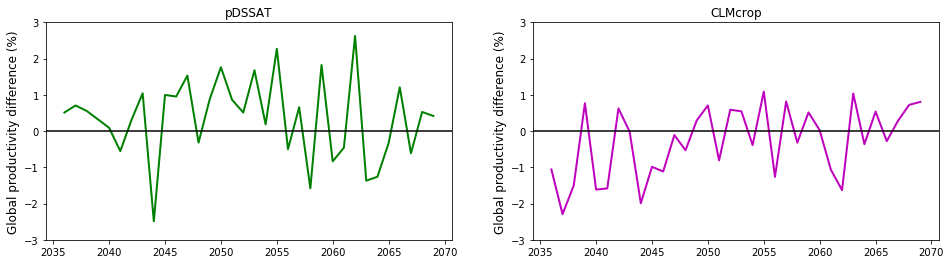

In [22]:
fig = plt.figure()
fig.set_size_inches(16,4)
#ax1 = fig.add_subplot(131)
#ax1.plot(time_clm,SSP245_nodif_sum,linewidth=2,color='r',linestyle='dashed',label="SSP2-4.5 diffuse off")
#ax1.plot(time_clm,SAI_nodif_sum,linewidth=2,color='b',linestyle='dashed',label="SSP2-4.5-SAI-1.5C diffuse off")
#ax1.plot(time_clm,SSP245_wdiffuse_prod_sum,linewidth=2,color='r',label="SSP2-4.5 diffuse on")
#x1.plot(time_clm,SAI_wdiffuse_prod_sum,linewidth=2,color='b',label="SSP2-4.5-SAI-1.5C diffuse on")
##x1.legend(loc="lower left", ncol=1, prop={'size': 10})
#ax1.set_title('pDSSAT production with diffuse vs. without diffuse',size=12)
#ax1.set_ylabel("Global maize production (Mt)",fontsize=13)
ax2 = fig.add_subplot(121)
ax2.plot(time_clm,diffuseminusnodif,linewidth=2,color='g',label="pDSSAT")
#ax2.plot(time_clm,clm_pchange,linewidth=2,color='m',label="CLMcrop")
ax2.set_title('pDSSAT',size=12,)
ax2.set_ylabel("Global productivity difference (%)",fontsize=12)
ax2.set_ylim([-3, 3])
ax2.axhline(y=0, color='k', linestyle='-',linewidth=1.5)
#ax2.axhline(y=0.072975, color='k', linestyle='-',linewidth=2)
ax3 = fig.add_subplot(122)
ax3.plot(time_clm,clm_pchange,linewidth=2,color='m',label="CLMcrop")
ax3.set_title('CLMcrop',size=12,)
ax3.set_ylabel("Global productivity difference (%)",fontsize=12)
ax3.set_ylim([-3, 3])
ax3.axhline(y=0, color='k', linestyle='-',linewidth=1.5)
#fig.suptitle('pDSSAT impact of including diffuse radiation', size=12, y=0.9999)
#plt.savefig(savedir+'/Fig4.png', dpi = 600, bbox_inches = 'tight', pad_inches = 0.05 )

In [23]:
#SAI_wdiffuse = SAI_wdiffuse.sel(lat=slice(-89.75,0))
#SSP245_wdiffuse = SSP245_wdiffuse.sel(lat=slice(-89.75,0))
#SAI_nodif = SAI_nodif.sel(lat=slice(-89.75,0))
#SSP245_nodif = SSP245_nodif.sel(lat=slice(-89.75,0))

SAI_wdiffuse_prod_avg = SAI_wdiffuse_prod.sel(time=slice('2050','2069'))
SAI_wdiffuse_prod_avg = SAI_wdiffuse_prod_avg.mean(dim='time')
SSP245_wdiffuse_prod_avg = SSP245_wdiffuse_prod.sel(time=slice('2050','2069'))
SSP245_wdiffuse_prod_avg = SSP245_wdiffuse_prod_avg.mean(dim='time')

SAI_nodif_prod_avg = SAI_nodif_prod.sel(time=slice('2050','2069'))
SAI_nodif_prod_avg = SAI_nodif_prod_avg.mean(dim='time')
SSP245_nodif_prod_avg = SSP245_nodif_prod.sel(time=slice('2050','2069'))
SSP245_nodif_prod_avg = SSP245_nodif_prod_avg.mean(dim='time')


wdiffuse_dif_map = (SAI_wdiffuse_prod_avg - SSP245_wdiffuse_prod_avg) / (SSP245_wdiffuse_prod_avg)
wdiffuse_dif_map = (wdiffuse_dif_map* 100)
#wdiffuse_dif_map_avg = wdiffuse_dif_map.sel(time=slice('2050','2069'))
#wdiffuse_dif_map_avg = wdiffuse_dif_map_avg.mean(dim='time')

nodif_dif_map = (SAI_nodif_prod_avg - SSP245_nodif_prod_avg) / (SSP245_nodif_prod_avg)
nodif_dif_map = (nodif_dif_map * 100)
#nodif_dif_map_avg = nodif_dif_map.sel(time=slice('2050','2069'))
#nodif_dif_map_avg = nodif_dif_map_avg.mean(dim='time')

diffuseminusnodif_map = (wdiffuse_dif_map - nodif_dif_map)

/glade/u/ssg/ch/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
SAI_wdiffuse_prod.max()

<xarray.DataArray ()>
array(2004029.625)

In [25]:
SSP245_wdiffuse_prod.max()

<xarray.DataArray ()>
array(1759816.125)

In [26]:
SAI_nodif_prod.max()

<xarray.DataArray ()>
array(2005986.125)

In [27]:
SSP245_nodif_prod.max()

<xarray.DataArray ()>
array(1762642.)

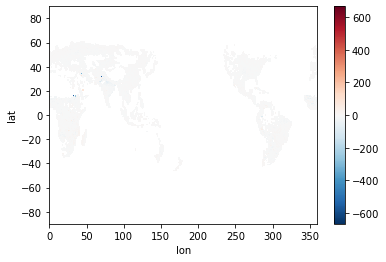

In [28]:
diffuseminusnodif_map.plot()

In [29]:
#SAI_wdiffuse_prod = SAI_wdiffuse_prod.sel(lat=slice(-89.75,0))
SAI_wdiffuse_prod_sum = SAI_wdiffuse_prod.sum(dim=['lat','lon'],skipna=True)

#SSP245_wdiffuse_prod = SSP245_wdiffuse_prod.sel(lat=slice(-89.75,0))
SSP245_wdiffuse_prod_sum = SSP245_wdiffuse_prod.sum(dim=['lat','lon'],skipna=True)

#SAI_nodif_prod = SAI_nodif_prod.sel(lat=slice(-89.75,0))
SAI_nodif_prod_sum = SAI_nodif_prod.sum(dim=['lat','lon'],skipna=True)

#SSP245_nodif_prod = SSP245_nodif_prod.sel(lat=slice(-89.75,0))
SSP245_nodif_prod_sum = SSP245_nodif_prod.sum(dim=['lat','lon'],skipna=True)

wdiffuse_dif = (SAI_wdiffuse_prod_sum - SSP245_wdiffuse_prod_sum) / (SSP245_wdiffuse_prod_sum)
wdiffuse_dif = wdiffuse_dif * 100

nodif_dif = (SAI_nodif_prod_sum - SSP245_nodif_prod_sum) / (SSP245_nodif_prod_sum)
nodif_dif = nodif_dif * 100

diffuseminusnodif = (wdiffuse_dif) - (nodif_dif)

In [30]:
cornprod_clm_case1 = cornyield_clm_case1 * maize_area_tot_sai
#cornprod_clm_case1 = cornprod_clm_case1.sel(lat=slice(-89.75,0))
cornprod_clm_case1_sum = cornprod_clm_case1.sum(dim=['lat','lon'],skipna=True)

cornprod_clm_case2 = cornyield_clm_case2 * maize_area_tot_sai
#cornprod_clm_case2 = cornprod_clm_case2.sel(lat=slice(-89.75,0))
cornprod_clm_case2_sum = cornprod_clm_case2.sum(dim=['lat','lon'],skipna=True)

clm_pchange = (cornprod_clm_case2_sum - cornprod_clm_case1_sum) / (cornprod_clm_case1_sum)
clm_pchange = clm_pchange * 100

In [32]:
clm_pchange_avg = clm_pchange.mean()
clm_pchange_avg

<xarray.DataArray ()>
array(-0.280919)
Coordinates:
    crops    float64 0.0
Attributes:
    units:    ton/ha/yr

In [33]:
diffuseminusnodif_mean = diffuseminusnodif.mean()
diffuseminusnodif_mean

<xarray.DataArray ()>
array(0.356621, dtype=float32)

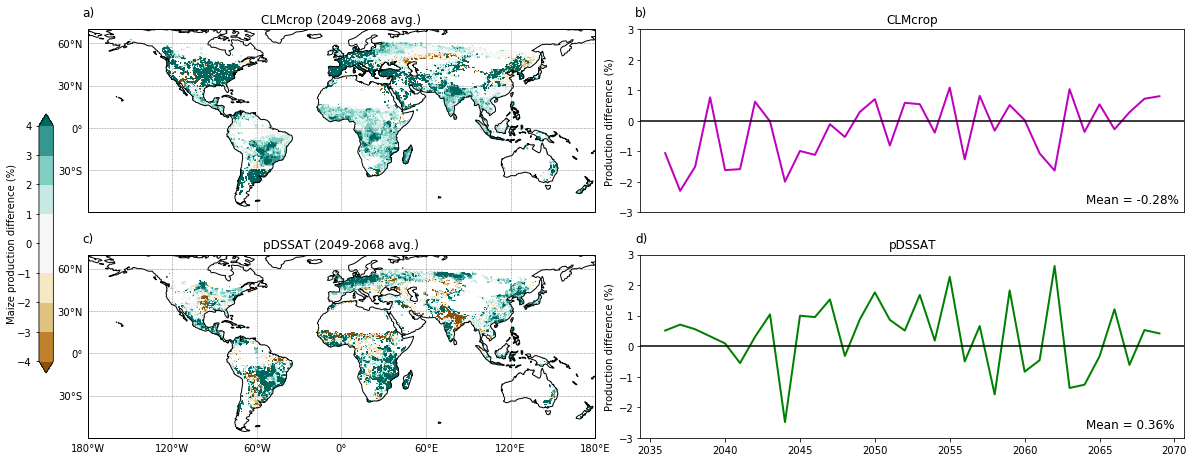

In [48]:
fut_levels = np.arange(-4, 5, 1)
fut_colors = ['#8c510a',
              '#bf812d',
              '#dfc27d',
              '#f6e8c3',
              '#f7f7f7',
              '#f7f7f7',
              '#c7eae5',
              '#80cdc1',
              '#35978f',
              '#01665e']

from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[2, 1])
fig = plt.figure(figsize=(20,9))
ax1 = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2],projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(spec[3])
cb1 = clm_dif_map.plot.contourf(ax=ax1, colors=fut_colors, levels=fut_levels, add_colorbar=False)
ax1.coastlines()
ax1.set_xlim(-180, 180)
ax1.set_ylim(-60, 70)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.xlabels_top = False
gl1.xlabels_bottom = False
gl1.ylabels_left = True
gl1.ylabels_right=False
gl1.xlines = True
#gl1.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl1.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'color': 'black'}
gl1.ylabel_style = {'color': 'black'}
#ax1.contourf(pval_clm.lon.values, pval_clm.lat.values, pval_clm.values, transform=ccrs.PlateCarree(), colors='none', levels=[0.5, 1], hatches=['///////'], add_colorbar=False)
#ax1.contourf(cprob_xa.lon.values, cprob_xa.lat.values, cprob_xa.values,
#             levels=[0.05, 1.0], colors='none', hatches=['///'],
#             transform=ccrs.PlateCarree())
ax1.title.set_text('CLMcrop (2049-2068 avg.)')
ax1.text(-0.01, 1.07, 'a)', transform=ax1.transAxes, size=12)

ax2.plot(time_clm,clm_pchange,linewidth=2,color='m',label="CLMcrop")
ax2.set_title('CLMcrop',size=12,)
ax2.set_ylabel("Production difference (%)",fontsize=10)
ax2.set_ylim([-3, 3])
ax2.axhline(y=0, color='k', linestyle='-',linewidth=1.5)
ax2.axes.get_xaxis().set_visible(False)
ax2.text(0.82, 0.05, 'Mean = -0.28%', transform=ax2.transAxes, size=12)
ax2.text(-0.01, 1.07, 'b)', transform=ax2.transAxes, size=12)

diffuseminusnodif_map.plot.contourf(ax=ax3, colors=fut_colors, levels=fut_levels, add_colorbar=False)
ax3.coastlines()
ax3.set_xlim(-180, 180)
ax3.set_ylim(-60, 70)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl3.xlabels_top = False
gl3.ylabels_left = True
gl3.ylabels_right=False
gl3.xlines = True
#gl2.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl3.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
gl3.xlabel_style = {'color': 'black'}
gl3.ylabel_style = {'color': 'black'}
#x2.contourf(pval_lpj.lon.values, pval_lpj.lat.values, pval_lpj.values, transform=ccrs.PlateCarree(), colors='none', levels=[0.5, 1], hatches=['///////'], add_colorbar=False)
#ax2.contourf(lprob_xa.lon.values, lprob_xa.lat.values, lprob_xa.values,
#             levels=[0.05, 1.0], colors='none', hatches=['///'],
#             transform=ccrs.PlateCarree())
ax3.title.set_text('pDSSAT (2049-2068 avg.)')
ax3.text(-0.01, 1.07, 'c)', transform=ax3.transAxes, size=12)

ax4.plot(time_clm,diffuseminusnodif,linewidth=2,color='g',label="pDSSAT")
#ax2.plot(time_clm,clm_pchange,linewidth=2,color='m',label="CLMcrop")
ax4.set_title('pDSSAT',size=12,)
ax4.set_ylabel("Production difference (%)",fontsize=10)
ax4.set_ylim([-3, 3])
ax4.axhline(y=0, color='k', linestyle='-',linewidth=1.5)
ax4.text(0.82, 0.05, 'Mean = 0.36%', transform=ax4.transAxes, size=12)
ax4.text(-0.01, 1.07, 'd)', transform=ax4.transAxes, size=12)

plt.tight_layout()
fig.subplots_adjust(bottom=0.3)
#left-right, up-down, horizontal length, vertical length
cbar_ax = fig.add_axes([0.175, 0.4, 0.01, 0.4])
cb = fig.colorbar(cb1, cax=cbar_ax, orientation='vertical',ticklocation='left')
cb.set_label("Maize production difference (%)",labelpad=0)
plt.subplots_adjust(hspace=0.23,wspace=-0.3)
#fig.suptitle('Southern hemisphere diffuse impact SSP2-4.5-SAI-1.5C minus SSP2-4.5', size=14,x=0.62, y=0.787)
plt.savefig(savedir+'/Fig5_JJ.png', dpi = 600, bbox_inches = 'tight', pad_inches = 0.05 )